# 1. Introduction:
<b>a) Defining problem statement  </b><br>
Pneumonia is an infection that inflames the air sacs in one or both human lungs. Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2015, 920,000 children under the age of 5 died from the disease. In the United States, pneumonia accounts for over 500,000 visits to emergency departments and over 50,000 deaths in 2015, keeping the ailment on the list of top 10 causes of death in the country.

There are multiple diagnosis methods possible to identify Pneumonia. Chest Radiograph(CXR) is the most commonly used diagnostic method performed by highly trained specialists. Pneumonia usually manifests itself as an area or areas of increased opacity in the lung area on CXR. Few other cases like bleeding, pulmonary edema(fluid overload), atelectasis(volume loss), Post radiation , lung cancer or surgical changes can also cause the areas of increased opacity on CXR. Another common reason for the areas of increased opacity on CXR is accumalation of fluid in the pleural space(outside the lungs). Highly trained specialists are required to correctly classify an increased opacity.

The Objective of the project is to build an efficient (Low false positives) algorithm to detect a visual signal for pneumonia by monitoring the lung opacity in chest radiographs. A faster, correct diagnosis of Pnemonia would result in reduced fatalities. 


<b>b) The need of the study/project  </b><br>
Though CXRs are the most commonly performed diagnostic method, it is complicated since the results are dependent on many factors such  as positioning of the patient and depth of inspiration. With high number of infections every year, clinicians are faced with the challenge of reading high volumes of CXRs. This causes fatigue and introduces human error. In addition,the high number of cases lead to delay in diagnosing Pnemonia. This waiting time or lead time could be fatal to the patients.

<b>c) Understanding business/social opportunity</b><br>
By building powerful model, this project aims to design a decision assist system, which highlights the infected area and provides hint to enables physicians to make efficient clinical decisions. 
As the model matures, the decision assist system could perform more automated decisions, thereby relieving the radiologists from the fatigue-driven visual inspection system.
Powerful AI models can deliver very fast (on-the-spot) clinical decisions.

In [1]:
!pip install ipynb

# 2. Data Report

<font color='darkorange'><b>2.1 Understanding how data was collected in terms of time, frequency and methodology <br></b>
Chest X-Ray Dataset is provided by US National Institutes of Health Clinical Center in collabration with  Radiological Society of North America (RSNA®). This dataset is the largest publicly available chest x-ray dataset. Dataset is extracted from the clinical PACS database at National Institutes of Health Clinical Center and consists of ~60% of all frontal chest x-rays in the hospital. Therefore this dataset is significantly more representative to the real patient population distributions and realistic clinical diagnosis challenges. <br> This dataset was collected in the year 2017. <br><br>
Data consists of 2 different sets(train and test) of DICOM files. Two .csv files which provides the labels and the classifications. <br>
A DICOM file is an image saved in the Digital Imaging and Communications in Medicine (DICOM) format. It contains an image from a medical scan, such as an Radiography, CT scan, Ultrasound or MRI. But we are interested in only the Chest xray.<br><br>
DataStructure:<br>
&nbsp;&nbsp;&nbsp;&nbsp;data<br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|---stage_2_train_images  --- directory which contains training DICOM image set.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|---stage_2_test_images   --- directory which contains test DICOM image set.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|---stage_2_train_labels.csv --- File which contains the patientid, boundary box(x,y,width, height), label<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|---stage_2_detailed_class_info.csv - File contains the patientid and the classifications<br>
    
<br>

DICOM files consists of metadata , by analysing it, I could get more information about when the data was collected and whether the DICOM is generated from CXR of Chest or any other source.


In [2]:
#import required libraries
import os
import io


import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pydicom
import cv2
import matplotlib.patches as patches
from ipynb.fs.full.dataset import preprocessData, getFolderPath
import json
import seaborn as sns
import skimage.io as io


<font color='darkorange'><b>2.2 Explore the given data files, classes and descriptions in different classes. <b> 

In [3]:
## update the root directory
root_dir = 'data'
#Load the classification of the patients based on the lung opacity. (stage_2_detailed_class_info.csv)
df_Classification = pd.read_csv(getFolderPath(root_dir, 'iTrainClass'))
df_Classification.head(5)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [4]:
#Load the label file(stage_2_train_labels.csv)
df_label = pd.read_csv(getFolderPath(root_dir, 'iLabels'))
df_label.head(5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [5]:
df_label.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [6]:
print('Classfication Table size: ', df_Classification.shape)
print('Unique patient ID in Classification list: ', df_Classification.patientId.nunique())
print('Label Table size: ', df_label.shape)
print('Unique patient ID in Labels list: ', df_label.patientId.nunique())

Classfication Table size:  (30227, 2)
Unique patient ID in Classification list:  26684
Label Table size:  (30227, 6)
Unique patient ID in Labels list:  26684


In [7]:
print('Unique Target Labels: ', df_label.Target.unique())

Unique Target Labels:  [0 1]


In [8]:
df_label.duplicated().value_counts()

False    30227
dtype: int64

In [9]:
print('Unique classifications present:')
df_Classification['class'].unique()

Unique classifications present:


array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

In [10]:
df_Classification.duplicated().value_counts()

False    26684
True      3543
dtype: int64

In [11]:
print('Unique x,y,width,height data when the Target is Normal or No Lung Opacity/Not Normal: ')
print("x: ", df_label[df_label.Target == 0].x.unique())
print("y: ", df_label[df_label.Target == 0].y.unique())
print("width: ", df_label[df_label.Target == 0].width.unique())
print("height: ", df_label[df_label.Target == 0].height.unique())

Unique x,y,width,height data when the Target is Normal or No Lung Opacity/Not Normal: 
x:  [nan]
y:  [nan]
width:  [nan]
height:  [nan]


In [12]:
print(df_Classification.shape)
print(df_label.shape)

(30227, 2)
(30227, 6)


In [13]:
df_Classification  = df_Classification.merge(df_label, left_index=True, right_index=True)
df_Classification.head()

,patientId_x,class,patientId_y,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [14]:
#verify the patient ID is same
df_Classification[df_Classification.patientId_x != df_Classification.patientId_y].shape

(0, 8)

In [15]:
df_Classification.shape

(30227, 8)

In [16]:
duplicateRowsDF = df_Classification[df_Classification.duplicated()]
duplicateRowsDF.head()

,patientId_x,class,patientId_y,x,y,width,height,Target


In [17]:
df_Classification.head()

,patientId_x,class,patientId_y,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [18]:
df_Classification = df_Classification.rename({'patientId_x':'patientId'}, axis=1)
df_Classification.drop(labels=['patientId_y'], axis=1, inplace=True)
df_Classification.head()

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1


In [19]:
print("Number of Patients with Pnemonia",df_Classification[df_Classification.Target== 1].patientId.nunique())
print("Unique Classification when Target = 0", df_Classification[df_Classification.Target == 0]['class'].unique())
print("Unique Classification when Target = 1", df_Classification[df_Classification.Target == 1]['class'].unique())

Number of Patients with Pnemonia 6012
Unique Classification when Target = 0 ['No Lung Opacity / Not Normal' 'Normal']
Unique Classification when Target = 1 ['Lung Opacity']


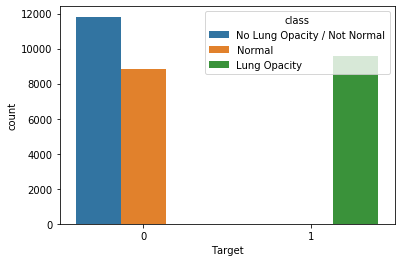

In [20]:
sns.countplot(x="Target", hue="class", data=df_Classification)

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


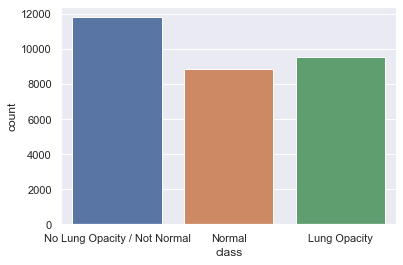

In [21]:
print (df_Classification['class'].value_counts())
sns.set(style="darkgrid")
sns.countplot(x="class", data=df_Classification)

<font color='blue'><b>Insights:<br></b>
  
1. Classification Table ( stage2_detailed_class_info.csv)<br>
&nbsp;&nbsp;&nbsp;&nbsp;a. patient ID - Patient ID<br>
&nbsp;&nbsp;&nbsp;&nbsp;d. class - Classification of image. there are 3 types of Classifications present:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&bull;Normal -  CXR objservation is normal, there is no Lung Opacity and abnormalities among 8851 patients<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&bull;Lung Opacity - CXR shows Lung opacity and This indicates that  16957 Patients have been affected by Pnemonia.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&bull;No Lung Opacity / Not Normal - CXR observation doesnt show any Lung Opacity but the CXR doesn't look normal in 11821 patients<br>

&nbsp;&nbsp;&nbsp;&nbsp;There are dublicate entries, but each entry has a corresponding entry in the Labels Dataframe. So I will retain these data.<br><br>
2. Labels Table ( stage2_train_labels.csv)<br>
&nbsp;&nbsp;&nbsp;&nbsp;a. patient ID - Patient ID<br>
&nbsp;&nbsp;&nbsp;&nbsp;b. x - X cordinates of the infected area<br>
&nbsp;&nbsp;&nbsp;&nbsp;c. y - Y cordinates of the infected area<br>
&nbsp;&nbsp;&nbsp;&nbsp;d. width - Width  of the infected area<br>
&nbsp;&nbsp;&nbsp;&nbsp;e. height - Height cordinates of the infected area<br>
&nbsp;&nbsp;&nbsp;&nbsp;f. Target - Classification <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&bull;label '1' : Classification is 'Lung Opacity' and the Opacity area is stored as x, y, width and height column. Incase Opacity is found in multiple places, multiple entry is present in the data with corresponding bounding box.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&bull;label '0' : Classification is either 'Normal' or 'No Lung Opacity / Not Normal'. abnormalities are not stored, so the boundingbox is empty.<br>
<br>
3. Training set consists of :<br>
&bull;Total Patients ID in Classification and Labels Table: 37629<br>
&bull;Total Unique Patient ID in Classification and Labels Table:  26684<br>
&bull;Lung Opacity:  16957<br>
&bull;No Lung Opacity / Not Normal :  11821<br>
&bull;Normal : 8851<br>
&bull;Number of Patients with Pnemonia : 6012<br>
&bull;Testing set consists of 3000 Patients(From the file count).<br>


<font color='darkorange'><b>2.3 Understanding of attributes (variable info, renaming if required)  </b>


In [22]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
patientId    30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [23]:
df_Classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
patientId    30227 non-null object
class        30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


In [24]:
df_Classification.nunique()

patientId    26684
class            3
x              748
y              726
width          351
height         725
Target           2
dtype: int64

In [25]:
#Find duplicate patientIDs
df_multiArea = df_Classification[df_Classification.duplicated('patientId', keep=False)]
df_multiArea.shape

(6941, 7)

In [26]:
#List the patient Ids which has more than 2 infected area.
df_multiArea_temp = df_multiArea.patientId.value_counts().reset_index(name="count").query("count > 2")
df_multiArea_temp.head()

,index,count
0,7d674c82-5501-4730-92c5-d241fd6911e7,4
1,76f71a93-8105-4c79-a010-0cfa86f0061a,4
2,1c44e0a4-4612-438f-9a83-8d5bf919cb67,4
3,ee820aa5-4804-4984-97b3-f0a71d69702f,4
4,8dc8e54b-5b05-4dac-80b9-fa48878621e2,4


<font color='blue'><b>Insights: </b>
1. df_Classification - Dataframe loaded from stage2_detailed_class_info and the merged with the df_label. This dataframe consists of 7 column<br>
    &bull;'patientId' - Patient Unique ID <br>
    &bull;'class' - contains the classification of the CXR for the given patient ID. But Column name 'class' misleads with the inbuilt attribute , so I will rename this column to 'classification'<br>
    &bull;x,y,width, height - infected area. From my analysis, multiple infected area could present. I will display this images with multiple infected area to understand them better. In addition, maintaining this information in a dictionary will be easier to access. So will convert this into dictionary object.  <br>  
    &bull;'Target' - 1- patients having Pnemonia. <br>0 - Patients CXR normal or No Lung Opacity/Not Normal
2. df_Label - Dataframe loaded from stage2_train_labels.csv. This consists of 6 column(Described in last section). 
    <br>

In [27]:
#rename the column name 'class'
df_Classification = df_Classification.rename({'class':'classification'}, axis=1)
df_Classification.head()

,patientId,classification,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1


# 3. Initial Exploratory data analysis 

<font color='darkorange'><b>3.1 Explore the DICOM files, Visualization of different classes, dealing with the issues of data quality, treating missing or duplicate values, if any. <br> </b>


In [28]:
# preprocess image folders and the .csv files and collect information from the DICOM files & print sample DICOM file

labelPath, df_dicomdata =preprocessData(root_dir, image_width= 256, image_height=256)


Sample DICOM File structure: 


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '1901010

In [29]:
print("Path to Label information:", labelPath) 

Path to Label information: data\train\trainlabels.npy


In [30]:
pd.options.display.float_format = '{:.0f}'.format
df_dicomdata.head()

,Filename,patientId,Name,Age,Sex,BodyPartExamined,Modality,StudyDate,StudyTime,Date,Rows,Columns,Sliceloc
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6,"0004cfab-14fd-4e49-80ba-63a80b6bddd6,",51,F,CHEST,CR,19010101,000000.00,1594579441,1024,1024,(missing)
1,000924cf-0f8d-42bd-9158-1af53881a557,000924cf-0f8d-42bd-9158-1af53881a557,"000924cf-0f8d-42bd-9158-1af53881a557,",19,F,CHEST,CR,19010101,000000.00,1594579441,1024,1024,(missing)
2,000db696-cf54-4385-b10b-6b16fbb3f985,000db696-cf54-4385-b10b-6b16fbb3f985,"000db696-cf54-4385-b10b-6b16fbb3f985,",25,F,CHEST,CR,19010101,000000.00,1594579441,1024,1024,(missing)
3,000fe35a-2649-43d4-b027-e67796d412e0,000fe35a-2649-43d4-b027-e67796d412e0,"000fe35a-2649-43d4-b027-e67796d412e0,",40,M,CHEST,CR,19010101,000000.00,1594579441,1024,1024,(missing)
4,001031d9-f904-4a23-b3e5-2c088acd19c6,001031d9-f904-4a23-b3e5-2c088acd19c6,"001031d9-f904-4a23-b3e5-2c088acd19c6,",57,M,CHEST,CR,19010101,000000.00,1594579441,1024,1024,(missing)


In [31]:
print("Difference in the Timestamp:", (df_dicomdata.Date.max() - df_dicomdata.Date.min()))

print("Sample date and time of a Dicom File: " , datetime.fromtimestamp(df_dicomdata.Date[0]))

print("Unique Modality values:", df_dicomdata.Modality.unique()) 
print("Unique Body Part Examined: ", df_dicomdata.BodyPartExamined.unique())
print("Unique Study Date Examined: ", df_dicomdata.StudyDate.unique())
print("Unique Study Time Examined: ", df_dicomdata.StudyTime.unique())

Difference in the Timestamp: 879.0981538295746
Sample date and time of a Dicom File:  2020-07-12 20:44:00.718788
Unique Modality values: ['CR']
Unique Body Part Examined:  ['CHEST']
Unique Study Date Examined:  ['19010101']
Unique Study Time Examined:  ['000000.00']


In [32]:
nPatients = df_dicomdata['patientId'].nunique()
nFiles = df_dicomdata['Filename'].nunique()

print ("No. of files" , nFiles)
print ("Total Unique Patients (Training dataset)" , nPatients)
print ("No. of Male patients" , df_dicomdata[df_dicomdata.Sex == 'M'].patientId.nunique())
print ("No. of Female patients" , df_dicomdata[df_dicomdata.Sex == 'F'].patientId.nunique())

if nFiles == nPatients:
    print ("Number of Patients and Number of Files are same. Possibly the one Files per patients are stored")
elif nFiles < nPatients:
    print ("Number of Patient are MORE than Number of Files. Possibly the Files are missing for few patients")
elif nFiles > nPatients:
    print ("Number of Patients are LESS than Number of Files. Possibly the more Files per patients are stored")

if df_dicomdata[df_dicomdata.Filename != df_dicomdata.patientId].empty:
    print ('Column PatientID and filenames contains same information. ')

if df_dicomdata[df_dicomdata.patientId != df_dicomdata.Name.str[:-2]].empty:
    print ('Patients Name is not provided. PatientID is stored as Patient Name. ')

No. of files 26684
Total Unique Patients (Training dataset) 26684
No. of Male patients 15166
No. of Female patients 11518
Number of Patients and Number of Files are same. Possibly the one Files per patients are stored
Column PatientID and filenames contains same information. 
Patients Name is not provided. PatientID is stored as Patient Name. 


In [33]:
print("Number of patients who are below 5 and above 70  :   ", df_dicomdata[(df_dicomdata.Age < 5) | (df_dicomdata.Age > 70)].shape[0])

Number of patients who are below 5 and above 70  :    1759


In [34]:
if (df_dicomdata['Rows'].nunique() == 1) & (df_dicomdata['Columns'].nunique() == 1) :
    print ("Image size across the Files are same.")

Image size across the Files are same.


In [35]:
label_dict = np.load(labelPath,allow_pickle='TRUE').item()
print('Patients who have Pnemonia in Training dataset: ', len(label_dict))

Patients who have Pnemonia in Training dataset:  6012


In [36]:
df_dicomdata['Sliceloc'].nunique()

1

In [37]:
#Drop unwanted columns
df_dicomdata.drop(['Filename', 'Name', 'BodyPartExamined','Modality', 'StudyDate', 'StudyTime', 'Date', 'Rows', 'Columns' , 'Sliceloc'], axis=1, inplace=True)
df_dicomdata.head()

,patientId,Age,Sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F
1,000924cf-0f8d-42bd-9158-1af53881a557,19,F
2,000db696-cf54-4385-b10b-6b16fbb3f985,25,F
3,000fe35a-2649-43d4-b027-e67796d412e0,40,M
4,001031d9-f904-4a23-b3e5-2c088acd19c6,57,M


In [54]:
df_dicomdata.describe()

,Age
count,26684
mean,47
std,17
min,1
25%,34
50%,49
75%,59
max,155


<font color='darkorange'>Check whether Age or Sex have influence on the classification.

In [38]:
#Check the Age column for any outliers. If available then remove it.
print(df_dicomdata.Age.unique())

[ 51  19  25  40  57  56  76  31  54  28  63  48  32  26  22  12  78  75
  23  59  49   6  70  58  36  73  43  60  21  72  52  55  53  16  71  77
  50  39  69  38  47  67  44  14  68  42  41  62  15  29   2  13  34  61
  35  66  45  74  30   7  46   3  37  85  20  27  64  17  33  24  65  18
   9  87  10  86  79  83  81  11  80   8   4  82  91   5  84  90  88  89
 148   1  92 151 153 150 155]


In [39]:
#There were few dataentry errors in Patients age which I have corrected. 
#Subtract 100 from the age which is greater than 110. 
df_dicomdata.loc[df_dicomdata.Age > 110]['Age'] = df_dicomdata.Age -100

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:

df_dicomdata['patientId'] = df_dicomdata['patientId']
df_Classification = pd.merge(df_Classification, df_dicomdata[['patientId', 'Age', 'Sex']], on='patientId', how='left')
df_Classification.head()

,patientId,classification,x,y,width,height,Target,Age,Sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,nan,nan,nan,nan,0,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,nan,nan,nan,nan,0,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,nan,nan,nan,nan,0,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,nan,nan,nan,nan,0,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264,152,213,379,1,32,F


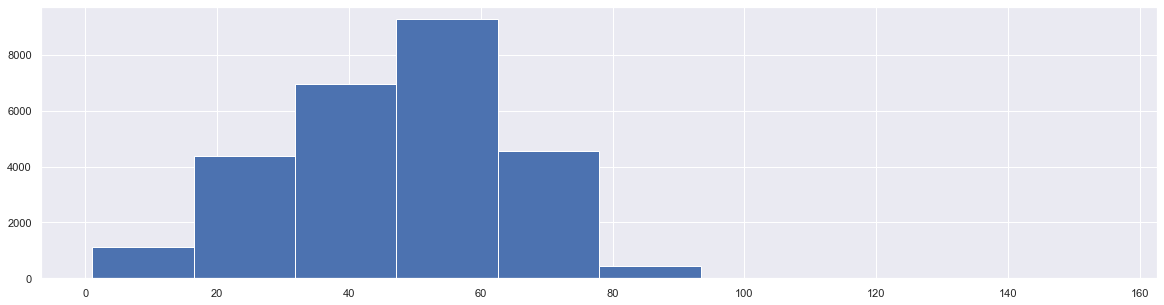

In [41]:
plt.figure(figsize=(20,5))
plt.hist(df_dicomdata.Age, bins = 10)
plt.show()

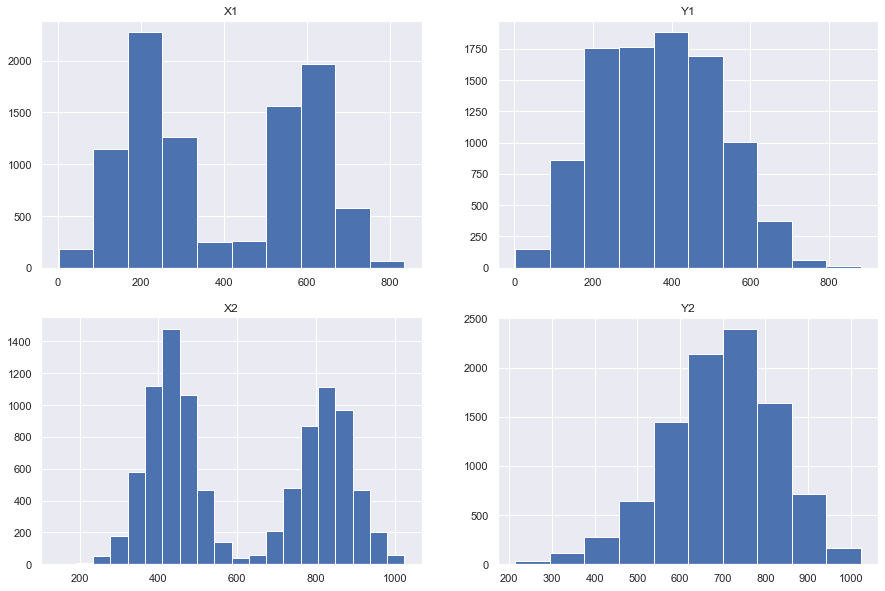

In [47]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(221)
plt.hist(df_Classification.x, bins = 10)
ax.set_title('X1')

ax = plt.subplot(222)
plt.hist(df_Classification.y, bins = 10)
ax.set_title('Y1')

ax = plt.subplot(223)
plt.hist( df_Classification.x + df_Classification.width, bins = 20)
ax.set_title('X2')


ax = plt.subplot(224)
plt.hist(df_Classification.y + df_Classification.height, bins = 10)
ax.set_title('Y2')

plt.show()

In [63]:
train_img_folder = os.path.join(root_dir,  'train')
#function which shows first 10 images from the list. If there is bounding box, the same is overlayed on top of the image.
def showImages(df):
    fig = None
    count = 0
    for patientID in df.patientId[0:9]:
        Notnormal_imgfile = patientID + '.png'# '00436515-870c-4b36-a041-de91049b9ab4.png'
        if count % 3 == 0:
            fig = plt.figure(figsize=[15,5])
        ax = fig.add_subplot(1 , 3, int (count % 3) +1)
        Notnormal_img= io.imread(os.path.join(train_img_folder, Notnormal_imgfile), as_gray=False )
        # Create a Rectangle patch
        
        if patientID in label_dict:
            for bbox in label_dict[patientID]:
                rect = patches.Rectangle((int(bbox[0]),int(bbox[1])),int(bbox[2]),int(bbox[3]),linewidth=2,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
        
        ax.set_title(patientID)
        plt.imshow(Notnormal_img, cmap =plt.cm.bone)
        count = count+1


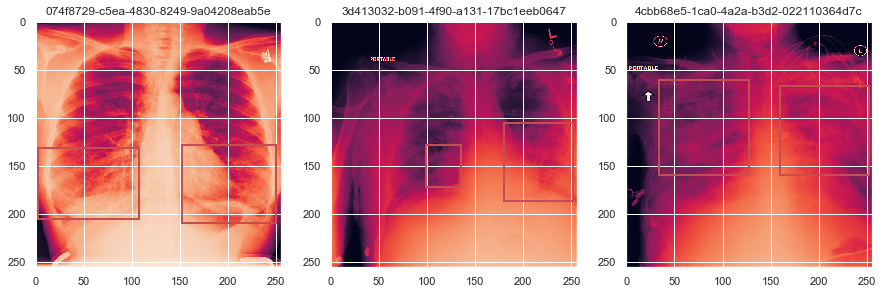

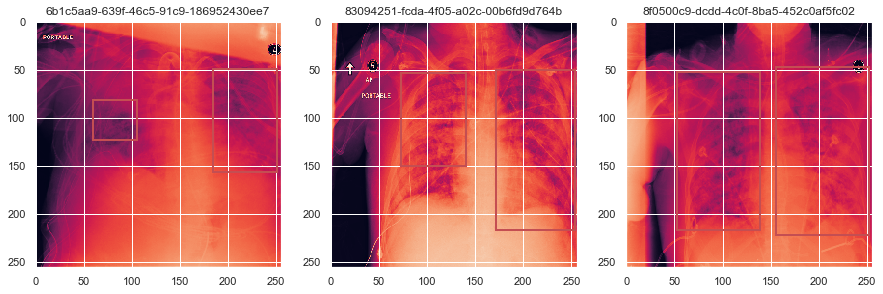

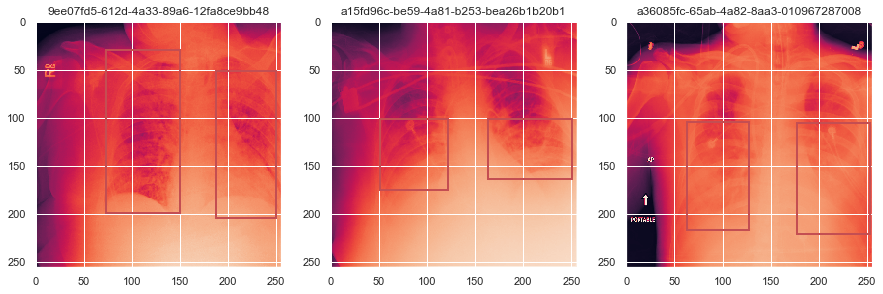

In [64]:
df_biggerpneumonia =df_Classification[(df_Classification.x + df_Classification.width) > 1000]
showImages(df_biggerpneumonia)

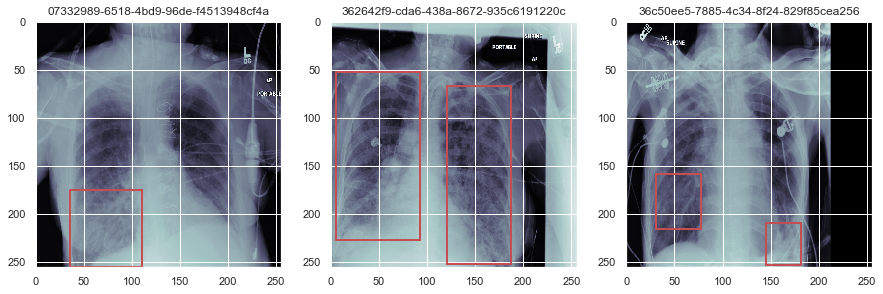

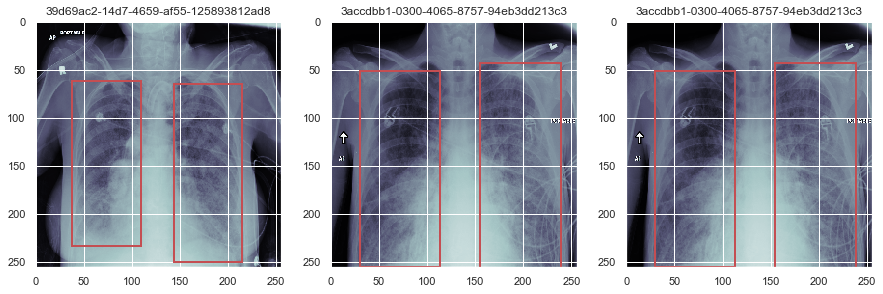

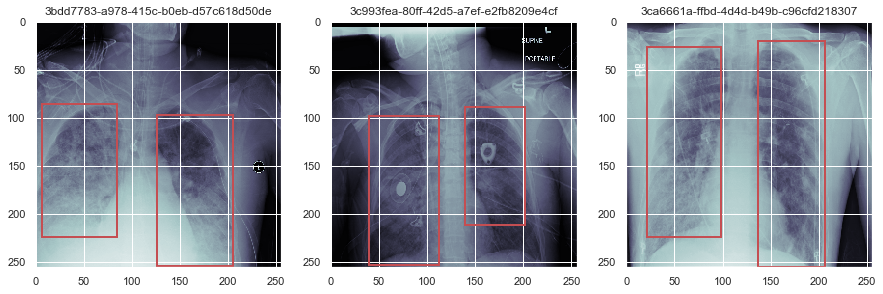

In [51]:
df_biggerpneumonia =df_Classification[(df_Classification.y + df_Classification.height) > 1000]
showImages(df_biggerpneumonia)

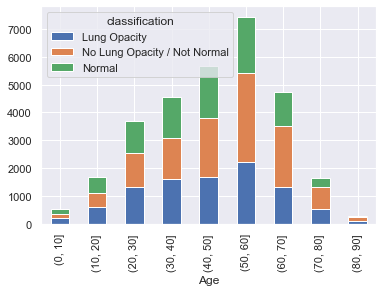

In [52]:
df_plot = df_Classification.groupby([pd.cut(df_Classification["Age"], np.arange(0, 100, 10)),  'classification']).size().reset_index().pivot(columns='classification', index='Age', values=0)
df_plot.plot(kind='bar', stacked=True)

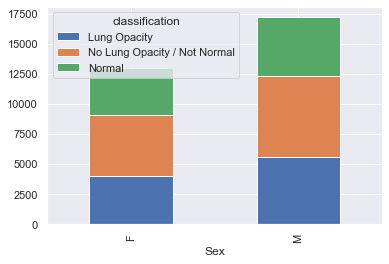

In [53]:
df_plot = df_Classification.groupby(['Sex',  'classification']).size().reset_index().pivot(columns='classification', index='Sex', values=0)
df_plot.plot(kind='bar', stacked=True)

<font color=darkorange><b> Sample Normal Images<b>

In [ ]:
df_normal=df_Classification[df_Classification.classification == 'Normal']
showImages(df_normal)

<font color=darkorange><b> Sample No Lung Opacity / Not Normal Images<b>

In [ ]:

df_notnormal =df_Classification[df_Classification.classification == 'No Lung Opacity / Not Normal']
showImages(df_notnormal)

<font color=darkorange><b> Sample Lung Opacity Images<b>

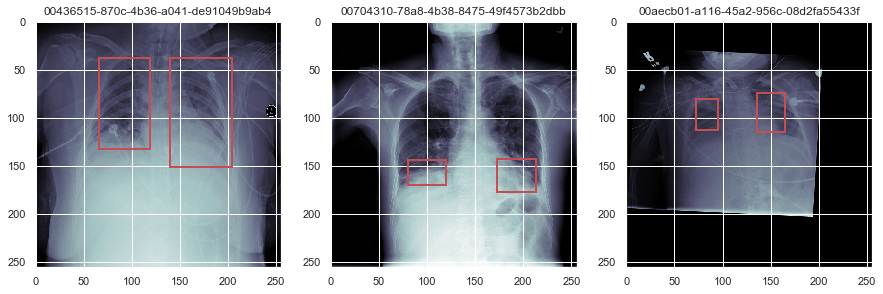

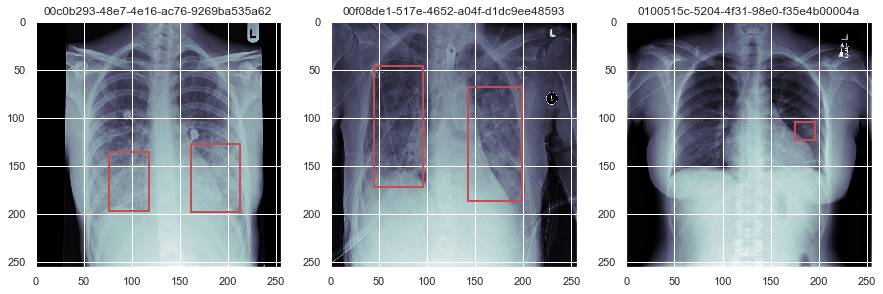

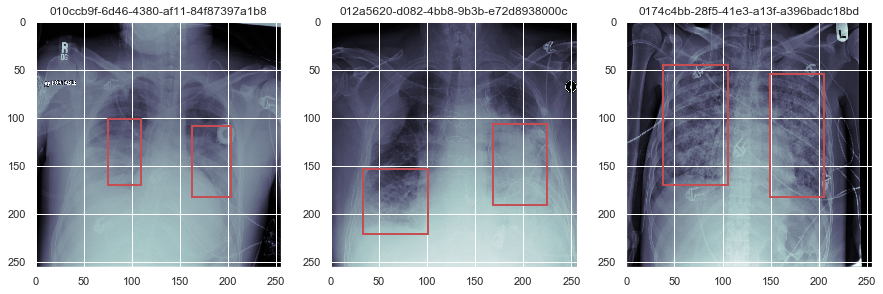

In [56]:
df_lungopacity =df_Classification[df_Classification.classification == 'Lung Opacity'].drop_duplicates(subset=['patientId'])
showImages(df_lungopacity)

<font color='darkorange'><b> CXR from Kids<b>

In [57]:
#3rd image looks smaller than the normal. Verifying the age to confirm it.
df_lungopacity.iloc[2,:]

patientId         00aecb01-a116-45a2-956c-08d2fa55433f
classification                            Lung Opacity
x                                                  288
y                                                  322
width                                               94
height                                             135
Target                                               1
Age                                                  6
Sex                                                  F
Name: 14, dtype: object

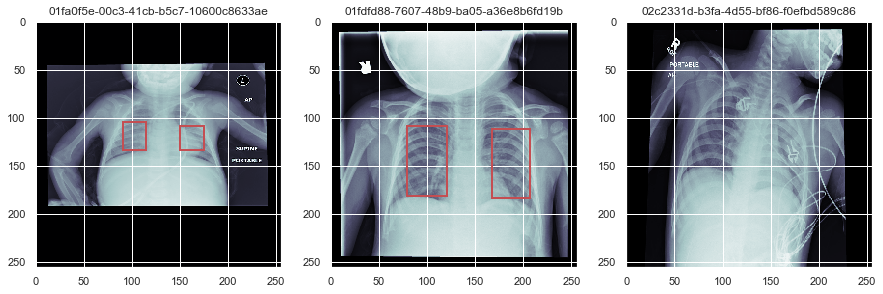

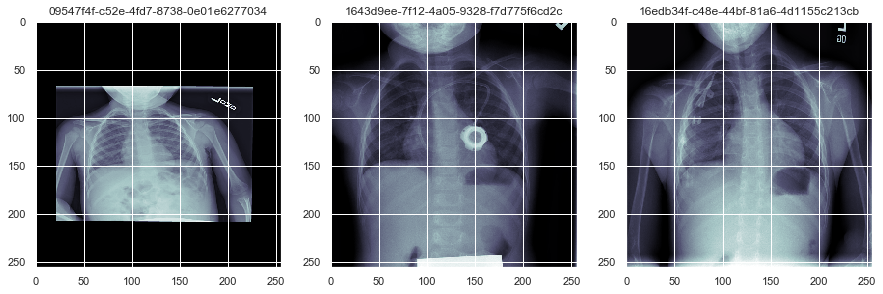

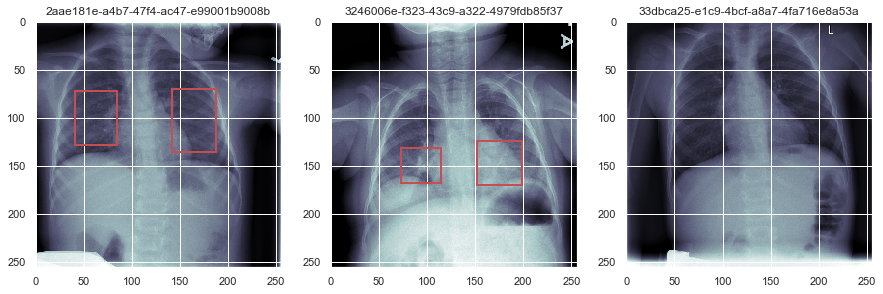

In [58]:
df_kids =df_Classification[df_Classification.Age < 5].drop_duplicates(subset=['patientId'])
showImages(df_kids)

<font color='darkorange'><b> CXR with more than 2 Infected Area<b>
In some cases, more than 2 infected area present. To verify whether they overlap on each other, I will display the images to understand it better.

In [ ]:
df_multiArea_temp = df_multiArea.patientId.value_counts().reset_index(name="count").query("count > 2")
df_multiArea_subset = df_multiArea[df_multiArea.patientId.isin(df_multiArea_temp['index'])].drop_duplicates(subset=['patientId'])
showImages(df_multiArea_subset)

<font color='blue'>Insights:<br>
1. DICOM Filename and Patient's ID is same and there is only one file exists for each patients. From this I infer that Patients were not re-examined again using CXR.<br>
<br>
2. From DICOM File structure, I could understand that DICOM file can store many information as Header information . Following information looks interesting to me:<br>
&bull;Study Date & Study Time   - Date and Time of the CXR was captured. both this column doesnt contain valid data and this was dropped.<br>
&bull;Modality                  - DICOM was captured with which equipment CXR, CT scan or MRI etc. Consists only 'CR' as i had expected. This column was dropped <br>
&bull;Patient's Name            - Patients Name - Unfortunately PatientId is stored as Name. This column was dropped.<br>
&bull;Patient ID                - Patients ID (Unique)<br>
&bull;Patient's Sex             - Male or Female. no influence on the final classification. <br>
&bull;Patient's Age             - Age of the Patient. No influence on the final classification. <br>
&bull;Body Part Examined        - Which part of the body is examined. We have got unique value'CHEST' in this column, so this was removed.<br>
&bull;Rows  & Columns           - Image size. Image height and width information is stored. All out images of same size (1024 x 1024). This column was dropped.<br>
&bull;Pixel Data                - Actual Image array.<br>
&bull;'Filename'                - DICOM File Name - patient ID is used as FileName , so this column was dropped<br>
<br>
3. label_dict - Dictionary object which consists of<br>
&bull;key - patientID who are affected by Pnemonia<br>
&bull;value - Array of Opacity area (Bounding box ). Points are corresponding to the imagesize<br>
<br>
4. Total Number of Male Patients: 15166 <br>
Total Number of Female Patients: 11518<br>
<br>
5. All Normal CXR has opacity in the bottom of left lung and these Opacity is not marked as infected area. So I assume that it as expected. <br><br>
6. From the Lung Opacity CXR images, it is clear that infection can be present in multiple area in a single CXR and the same is captured. Infected area can intersect on each other.<br>
<br>
7. When the CXR is taken for small kids, the images are smaller than normal. This can be confirmed from the 3rd image in the Lung Opacity category. When I analysed further, I noticed that positioning of younger patients is not uniform. I may have to perform Data augumentation technique to resolve this.<br><br>
8. While comparing the images(Not normal and Lung Opacity), I could not differentiate between the Lung Opacity and the abnormalities. I should take help from the domain experts to get better understanding, <br>
<br>
<b>Files generated after preprocessing:</b><br>
DataStructure:<br>
&nbsp;&nbsp;&nbsp;&nbsp;data<br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|---train  --- directory which contains training images(.png files) which were generated after resizing the image.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|---trainlabels.npy   --- Numpy. dictionary object which were retrieved from the stage_2_train_labels.csv file. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;This dictionary consists of patientId as key and the bounding box arrays as values.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;Dictionary contains the patientIds who were affected by pnemonia.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|---test --- directory which contains test images(.png files) which were generated after resizing the image.<br>

<font color=darkorange><b>3.3 Present the analysis from the visualization of the different classes.  

<font color='blue'><b>Summary:</b><br>
1. Label and Classification table contains multiple entries for some Patient IDs. They are not duplicate information. This depicts that multple infected area present in single image. This multiple infections can be viewed clearly in the above image (under 'Lung Opacity' )
2. In CXR, Positioning of younger patients are not uniform. I may have to perform Data augumentation technique to resolve this.
3. 94% of the samples belongs to the Patients who are in the Age group 5-70 years. But fatality statistics indicate that patients in the age group below 5 and above 70 are more likely to die from Pnemonia. Irrespective of age group, the rate of Pnemonia risk with in the age group is same. As a conclusion Age is not a key criteria.
4. With in Male and Female group, the rate of Pnemonia risk is same. So, Sex doesnt have any influence on the classification
5. Classifications present:
    
|Classifiations|	Target/Pnemonia|	Infected Area	|Remarks|
|:--|--:|:--|:--|
|Normal|	0	|No|CXR Objservation is normal.<br> No Lung opacity present.<br> This implies that there is no infected area thus No Area coordinates stored  instead nan is present. |
|No Lung Opacity / Not Normal 	|0	|No	|CXR Objservation is Not normal.<br> No Lung opacity present. <br>This implies that there is no lung infection but the CXR shows some abnormalities. This abnormalities could be due to muliple factors like bleeding, pulmonary edema(fluid overload), atelectasis(volume loss), Post radiation , lung cancer or surgical changes or accumalation of fluid in the pleural space(outside the lungs). <br>Since this abnormalities are not related to Pnemonia, no Area coordinates are stored instead nan is present.  |
|Lung Opacity	|1	|Yes(can be multiple)	| CXR shows Lung opacity and this indicates that Patients have been affected by Pnemonia. <br>In some images, Opacity presents in multiple location. Respective area coordinates are captured and stored, so multiple entries present for the same image/patientID in the label file. <br>Currently the area is stored as an Array. example [[x,y,width,height][x,y,width, height]]. Based on the model I choose, I will update this structure.|

As per the Project brief, the objective is to find the Pnemonia in the given CXR. Finding potential Pnemonia is critial  in order to prioritize and expedite the clinician's review. As a next step, verifying the reason behind the abnormalities ('No Lung Opacity / Not Normal') is important as lead time should not cause fatalities among these patients. So I would suggest to build a model which produces  3 classification(0 - Normal, 1 - Pnemonia, 2- abnormalities).

In [ ]:
df_Classification.to_csv('classification.csv',index=False)

In [ ]:
df_temp = pd.read_csv('classification.csv')
df_temp.head()